**Binary Classification**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as mno
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

import shap
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, \
                                    StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, \
                            precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder

from pprint import pprint

from vecstack import StackingTransformer

RANDOM_STATE = 1805

ModuleNotFoundError: ignored

In [0]:
train_data = pd.read_csv('Data/ref_train_x.csv')
train_labels = pd.read_csv('Data/ref_train_y.csv', header=None)
test_data = pd.read_csv('Data/ref_test_x.csv')

# sp500_valid_data.columns = sp500_train_data.columns
# sp500_test_data.columns = sp500_train_data.columns

In [0]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(15249, 23)
(15249, 1)
(4191, 23)


In [0]:
def plot_lift_curve(y_true, y_prob, model_name, ax):
    """ Lift Curve """
    # Construct Lift Curve
    df = pd.DataFrame(np.array([y_true, y_prob]).T,columns=['true','soft'])
    df.sort_values(by='soft',ascending=False,inplace=True)
    lift = pd.concat([df.groupby('soft').count(),df.groupby('soft').sum()],axis=1)
    lift.sort_index(ascending=False,inplace=True)
    lift.columns = ['strate size','positive']
    lift['negative'] = lift['strate size'] - lift['positive']
    n_positive = df['true'].sum()
    n_negative = df['true'].count()-n_positive
    lift.index.name = 'threshold'
    lift['Group size'] = lift['strate size'].cumsum()
    lift['Group hit probability'] = lift['positive'].cumsum() / lift['Group size']
    lft = lift['Group hit probability'].values / (n_positive /(n_positive+n_negative))
    gr = lift['Group size'].values / len(y_true)
    mx = np.max(lft * (gr >= 0.1))

    # Plot Lift Curve
    label_name = '{}'.format(model_name)
    ax.plot(gr, lft, color='blue', label=label_name)
    ax.axhline(1.0, color='red', ls='--', label='Random guess')
    ax.set_title('Lift Curve', fontsize=13, weight='bold')
    ax.set_xlabel('Decile', fontsize=13)
    ax.set_ylabel('Lift', fontsize=13)
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1.3*mx))
    ax.grid(True)
    ax.legend(loc='best')
    return ax

def plot_roc_curve(y_true, y_prob, model_name, ax):
    """ ROC Curve """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    label_name = '{} (AUC={})'.format(model_name, round(roc_auc, 2))
    ax.plot(fpr, tpr, color='blue', label=label_name)
    ax.plot([0, 1], [0, 1], color='red', ls='--', label='Random guess')
    ax.set_title('ROC Curve', fontsize=13, weight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.legend(loc='best')
    ax.grid(True)
    return ax

def plot_precision_recall_curve(y_true, y_prob, model_name, ax):
    """ Precision-Recall Curve """
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    label_name = '{} (AP={})'.format(model_name, round(ap, 2))
    ax.plot(precision, recall, color='blue', label=label_name)
    ax.axhline(ap, color='red', ls='--', label='Average precision')
    ax.set_title('Precision Recall Curve', fontsize=13, weight='bold')
    ax.set_xlabel('Precision', fontsize=13)
    ax.set_ylabel('Recall', fontsize=13)
    ax.grid(True)
    ax.legend(loc='best')
    return ax

def plot_discrimination_threshold(y_true, y_prob, ax):
    """ Discrimination Threshold Plot """
    # Test Multiple Thresholds
    thresholds = np.arange(0.001, 0.999, 0.1)
    precisions, recalls, f1_scores = [], [], []
    for t in thresholds:
        y_pred_temp = (y_prob > t).astype(int)
        precision_temp = precision_score(y_true, y_pred_temp)
        recall_temp = recall_score(y_true, y_pred_temp)
        f1_score_temp = f1_score(y_true, y_pred_temp)
        precisions.append(precision_temp)
        recalls.append(recall_temp)
        f1_scores.append(f1_score_temp)

    # Plot
    ap = average_precision_score(y_true, y_prob)
    ax.plot(thresholds, precisions, color='blue', label='Precision')
    ax.plot(thresholds, recalls, color='darkorange', label='Recall')
    ax.plot(thresholds, f1_scores, color='green', label='$F_1$ Score')
    ax.axhline(ap, color='red', ls='--', label='Avg. Precision')
    ax.legend(loc='best')
    ax.set_xlabel('Threshold', fontsize=13)
    ax.set_title('Binary Classification Threshold', fontsize=13, weight='bold')
    return ax

# **Exploratory Data Analysis**

In [0]:
train_data = train_data.drop('raw_id', axis=1)

## Missing Values

In [0]:
train_data.isnull().sum().sort_values() / len(train_data)

sector                    0.000000
exchange                  0.000000
return_1y                 0.000066
return_1m                 0.000066
return_1w                 0.000066
realised_vol_1y           0.000131
realised_vol_1w           0.000197
realised_vol_1m           0.000197
implied_vol_3m            0.000328
delta_vol_1w              0.000656
publication_date_funda    0.000984
net_income                0.001115
sales                     0.001180
earnings_implied_obs      0.001312
net_debt                  0.001312
shareholders_equity       0.001377
cash_flow                 0.001705
payout_ratio              0.006164
ratio_put_call            0.006230
delta_vol_1y              0.014952
ebit                      0.122303
ebitda                    0.122565
dtype: float64

## Categorical & Numerical Variables

In [0]:
train_data.nunique().sort_values()

exchange                      2
sector                       20
publication_date_funda      401
payout_ratio               5163
earnings_implied_obs      11224
ebitda                    12262
ebit                      12264
delta_vol_1w              13004
delta_vol_1y              13588
implied_vol_3m            13659
ratio_put_call            13971
sales                     14005
cash_flow                 14010
shareholders_equity       14013
net_debt                  14014
net_income                14017
return_1w                 14075
return_1y                 14077
realised_vol_1w           14080
return_1m                 14080
realised_vol_1m           14080
realised_vol_1y           14081
dtype: int64

In [0]:
# train_data['publication_date_funda']

In [0]:
categorical_variables = ['sector', 'exchange']
categorical_variables_plus = ['sector', 'exchange']
numerical_variables = [col for col in train_data.columns if col not in categorical_variables_plus]

In [0]:
print(len(numerical_variables))
print(len(categorical_variables_plus))

19
3


## Target Distribution

In [0]:
y = train_labels.values.squeeze()

In [0]:
np.mean(y)

0.26768968456947995

# **Feature Engineering**

## Categorical Features

**One-Hot Encoding = Linear Models**

In [0]:
%%time
# train_data_ = train_data.drop('publication_date_funda', axis=1)

oneHotTransformer = OneHotEncoder(cols=categorical_variables)
oneHotTransformer.fit(train_data)

X_train_cat = oneHotTransformer.transform(train_data)
print(X_train_cat.shape)

(15249, 44)
Wall time: 103 ms


**Label Encoding = Random Forests + XGBoost + LightGBM**

In [0]:
%%time
labelTransformer = OrdinalEncoder(cols=categorical_variables_plus)
labelTransformer.fit(train_data_)

X_train_cat_label = labelTransformer.transform(train_data)
print(X_train_cat_label.shape)

(15249, 22)
Wall time: 184 ms


**Target Encoding = All Models**

In [0]:
train_data.shape, y.shape

((15249, 22), (15249,))

In [0]:
%%time
targetEncoder = TargetEncoder(cols=categorical_variables_plus)
targetEncoder.fit(train_data, y)

X_train_cat_target = targetEncoder.transform(train_data)
print(X_train_cat_target.shape)

(15249, 22)
Wall time: 4.03 s


In [0]:
X_train_cat_target[categorical_variables_plus].head()

,sector,exchange,publication_date_funda
0,0.145929,0.257221,0.268765
1,0.145929,0.257221,0.120690
2,0.145929,0.257221,0.085714
3,0.145929,0.257221,0.272727
4,0.145929,0.257221,0.167883


## Missing Values

**Linear Models**

In [0]:
imputer = SimpleImputer(strategy='median')
X_train_linear = imputer.fit_transform(X_train_cat)
X_train_linear = pd.DataFrame(X_train_linear, columns=X_train_cat.columns,
                              index=X_train_cat.index)

In [0]:
X_train_linear.isnull().sum().sum()

0

**Random Forests**

In [0]:
imputer = SimpleImputer(strategy='median')
X_train_rf = imputer.fit_transform(X_train_cat_label)
X_train_rf = pd.DataFrame(X_train_rf, columns=X_train_cat_label.columns,
                          index=X_train_cat_label.index)

**XGBoost + LightGBM**

In [0]:
X_train_boost = X_train_cat_label.copy()

In [0]:
X_train_boost = X_train_cat_target.copy()

## Feature Scaling

**Linear Models**

In [0]:
scaler = StandardScaler()
X_train_linear[numerical_variables] = \
            scaler.fit_transform(X_train_linear[numerical_variables])

In [0]:
# X_train_linear[numerical_variables].head()

**Random Forests + XGBoost + LightGBM**

In [0]:
# SKIP

## Feature Selection

In [0]:
df = X_train_cat_target.copy()
df['target'] = y

In [0]:
label_correlation = df.corr()

In [0]:
label_correlation['target'].sort_values(ascending=False)

target                    1.000000
publication_date_funda    0.174779
sector                    0.109732
realised_vol_1y           0.045600
exchange                  0.027339
sales                     0.024152
implied_vol_3m            0.020798
ebitda                    0.016816
ratio_put_call            0.016345
ebit                      0.011425
return_1w                 0.008005
realised_vol_1m           0.005082
net_debt                  0.003989
cash_flow                -0.000559
realised_vol_1w          -0.001604
delta_vol_1y             -0.001810
shareholders_equity      -0.002732
net_income               -0.008333
payout_ratio             -0.013128
return_1m                -0.017020
delta_vol_1w             -0.018503
return_1y                -0.030696
earnings_implied_obs     -0.031345
Name: target, dtype: float64

## New Features

In [0]:
X_train_linear['']

# **Model Training**

In [0]:
print('Linear Models :\t', X_train_linear.shape)
print('Random Forests:\t', X_train_rf.shape)
print('Gradient Boost:\t', X_train_boost.shape)

Linear Models :	 (15249, 43)
Random Forests:	 (15249, 22)
Gradient Boost:	 (15249, 22)


## Logistic Regression

In [0]:
logit = LogisticRegression(penalty='l1', C=1.0, solver='liblinear',
                           class_weight='balanced', random_state=RANDOM_STATE)

In [0]:
%%time
lr_scores = cross_val_score(logit, X=X_train_linear, y=y, cv=10,
                            verbose=0, scoring='roc_auc')
print(lr_scores)

[0.61164313 0.59895853 0.5799476  0.56474801 0.62350791 0.58681342
 0.58444363 0.55677665 0.55630666 0.59174705]
Wall time: 1.46 s


In [0]:
print('Mean CV:\t', np.mean(lr_scores))
print('StDev CV:\t', np.std(lr_scores))

Mean CV:	 0.5854892588548503
StDev CV:	 0.021189189694348534


In [0]:
# y_valid_pred_logit = cross_val_predict(logit, X_train_cat_target, y, cv=10,
#                                        method='predict_proba')[:,1]

In [0]:
# f, ax = plt.subplots(2, 2, figsize=(12,10))
# plot_lift_curve(y, y_valid_pred_logit, model_name='Logit', ax=ax[0,0])
# plot_roc_curve(y, y_valid_pred_logit, model_name='Logit', ax=ax[0,1])
# plot_precision_recall_curve(y, y_valid_pred_logit, model_name='Logit',
#                             ax=ax[1,0])
# plot_discrimination_threshold(y, y_valid_pred_logit, ax=ax[1,1])
# plt.show()

In [0]:
logit.fit(X_train_linear, y);

In [0]:
pd.Series(logit.coef_[0], X_train_linear.columns).sort_values()

sector_20              -2.045513
sector_1               -0.835505
sector_4               -0.435892
earnings_implied_obs   -0.265281
sector_13              -0.235964
sector_6               -0.226299
sector_15              -0.144925
sector_12              -0.094070
cash_flow              -0.084132
return_1m              -0.076910
realised_vol_1m        -0.074090
net_income             -0.073705
return_1y              -0.070948
delta_vol_1w           -0.070068
payout_ratio           -0.063411
realised_vol_1w        -0.059944
sector_16              -0.058823
exchange_1             -0.042849
ebit                   -0.042091
sales                  -0.028395
sector_19              -0.013258
sector_-1               0.000000
exchange_-1             0.000000
sector_5                0.000000
delta_vol_1y            0.000818
shareholders_equity     0.016005
ratio_put_call          0.018810
sector_10               0.020560
net_debt                0.030651
return_1w               0.043073
sector_2  

## Random Forests

In [0]:
randomForestClassifier = RandomForestClassifier(n_estimators=100,
                                                class_weight='balanced',
                                                max_depth=8,
                                                random_state=RANDOM_STATE)

In [0]:
%%time
cv_scores = cross_val_score(randomForestClassifier, X=X_train_linear, y=y,
                            cv=5, verbose=0, scoring='roc_auc')
print(cv_scores)

[0.60017872 0.58956113 0.59162638 0.55623864 0.55838009]
Wall time: 46.7 s


In [0]:
print('Mean CV:\t', np.mean(cv_scores))
print('StDev CV:\t', np.std(cv_scores))

Mean CV:	 0.5791969931264329
StDev CV:	 0.018234952030821292


In [0]:
randomForestClassifier.fit(X_train_linear, y);

## Extra Trees

In [0]:
extraForestClassifier = ExtraTreesClassifier(n_estimators=200,
                                             class_weight='balanced',
                                             max_depth=8,
                                             random_state=RANDOM_STATE)

In [0]:
%%time
cv_scores = cross_val_score(extraForestClassifier, X=X_train_linear, y=y,
                            cv=5, verbose=0, scoring='roc_auc')
print(cv_scores)

[0.58202762 0.54656587 0.58311381 0.55368448 0.55988493]
Wall time: 4.4 s


In [0]:
print('Mean CV:\t', np.mean(cv_scores))
print('StDev CV:\t', np.std(cv_scores))

Mean CV:	 0.5650553407741231
StDev CV:	 0.014913460900475965


## XGBoost

In [0]:
pd.Series(y).value_counts()

0    11167
1     4082
dtype: int64

In [0]:
scale_pos = 11167.0 / 4082.0
scale_pos

2.7356687898089174

In [0]:
%%time
#nb_classes = len(np.unique(y_resampled))

xgb_train = xgb.DMatrix(X_train_linear, label=y)

xgb_hyperparameters = {'booster': 'gbtree',
                       'tree_method': 'hist',
                       'eta': 0.05,
                       'colsample_bytree': 1.0,
                       'subsample': 1.0,
                       'objective': 'binary:logistic',
                       'max_depth': 8,
                       'alpha': 0.001,
                       'lambda': 0.001,
                       #'num_class': nb_classes,
                       'eval_metric': 'auc',
                       'scale_pos_weight': scale_pos,
                       'seed': RANDOM_STATE
                      }

xgb_classifier_cv = xgb.cv(xgb_hyperparameters, xgb_train, nfold=5, maximize=True,
                           verbose_eval=5, num_boost_round=200,
                           early_stopping_rounds=None)

[0]	train-auc:0.618593+0.00379085	test-auc:0.561905+0.00783256
[5]	train-auc:0.715449+0.00763324	test-auc:0.585504+0.00668753
[10]	train-auc:0.741873+0.0102104	test-auc:0.594501+0.00972547
[15]	train-auc:0.759723+0.0090067	test-auc:0.598741+0.00501402
[20]	train-auc:0.77338+0.00823431	test-auc:0.601427+0.00745578
[25]	train-auc:0.784304+0.00683446	test-auc:0.603954+0.00820449
[30]	train-auc:0.794278+0.00504246	test-auc:0.605411+0.00772943
[35]	train-auc:0.803886+0.00558999	test-auc:0.607322+0.00731381
[40]	train-auc:0.816298+0.00480723	test-auc:0.61003+0.00666741
[45]	train-auc:0.825555+0.00570436	test-auc:0.612178+0.0078929
[50]	train-auc:0.834417+0.00627258	test-auc:0.614182+0.00781652
[55]	train-auc:0.840786+0.00565658	test-auc:0.614204+0.00810798
[60]	train-auc:0.849953+0.00574735	test-auc:0.615949+0.00730276
[65]	train-auc:0.856701+0.00494065	test-auc:0.617756+0.00624823
[70]	train-auc:0.863546+0.00338755	test-auc:0.620051+0.00516521
[75]	train-auc:0.869151+0.00313304	test-auc:0.6

In [0]:
class xgboostClassifier(BaseEstimator, ClassifierMixin):
    """ AAA
    """
    def __init__(self, xgb_params):
        """ AAA """
        self.xgb_params = xgb_params
        
    def fit(self, X, y, num_rounds=50, maximize=False):
        """ AAA """
        xgb_params = self.xgb_params
        xgb_train = xgb.DMatrix(X, label=y)
        clf = xgb.train(xgb_params, xgb_train, maximize=maximize,
                        verbose_eval=0, num_boost_round=num_rounds,
                        early_stopping_rounds=None)
        self.clf = clf
        return self
        
    def predict(self, X):
        """ AAA """
        clf = self.clf
        xgb_test = xgb.DMatrix(X)
        preds = clf.predict(xgb_test)
        return preds

In [0]:
%%time
nb_xgb_optimal = 50
xgb_classifier = xgboostClassifier(xgb_hyperparameters)
_ = xgb_classifier.fit(X_train_boost, y, num_rounds=nb_xgb_optimal,
                       maximize=False)

Wall time: 872 ms


## LightGBM

In [0]:
lgb_hyperparameters = {'objective': 'binary',
                       'boosting_type': 'gbdt',
                       'metric': 'auc',
                       'reg_lambda': 1.0,
                       'reg_alpha': 3.0,
                       'class_weight': 'is_unbalance',
                       'max_depth': 8,
                       'num_leaves': 150,
                       'feature_fraction': 0.1,
                       'learning_rate': 0.1,
                       #'num_class': nb_classes,
                       'random_state': RANDOM_STATE
                       }

lgb_train = lgb.Dataset(X_train_boost, label=y)

lgbm_classifier = lgb.cv(lgb_hyperparameters, lgb_train, num_boost_round=200,
                         early_stopping_rounds=None, nfold=5, verbose_eval=10)

[10]	cv_agg's auc: 0.565335 + 0.00516514
[20]	cv_agg's auc: 0.608143 + 0.00748078
[30]	cv_agg's auc: 0.615761 + 0.0045813
[40]	cv_agg's auc: 0.616183 + 0.0060167
[50]	cv_agg's auc: 0.624931 + 0.00633922
[60]	cv_agg's auc: 0.625054 + 0.00650168
[70]	cv_agg's auc: 0.625616 + 0.00479063
[80]	cv_agg's auc: 0.623756 + 0.00527575
[90]	cv_agg's auc: 0.623713 + 0.00571367
[100]	cv_agg's auc: 0.629824 + 0.0064344
[110]	cv_agg's auc: 0.632892 + 0.00607314
[120]	cv_agg's auc: 0.634659 + 0.00674514
[130]	cv_agg's auc: 0.633914 + 0.00693513
[140]	cv_agg's auc: 0.635625 + 0.00782938
[150]	cv_agg's auc: 0.636663 + 0.00796397
[160]	cv_agg's auc: 0.638032 + 0.00815998
[170]	cv_agg's auc: 0.639282 + 0.00753822
[180]	cv_agg's auc: 0.640181 + 0.00802253
[190]	cv_agg's auc: 0.640327 + 0.00773685
[200]	cv_agg's auc: 0.640143 + 0.00843147


In [0]:
class lightgbmClassifier(BaseEstimator, ClassifierMixin):
    """ AAA
    """
    def __init__(self, lgb_params):
        """ AAA """
        self.lgb_params = lgb_params
        
    def fit(self, X, y, num_rounds=50):
        """ AAA """
        lgb_params = self.lgb_params
        lgb_train = lgb.Dataset(X, label=y)
        clf = lgb.train(lgb_params, lgb_train, verbose_eval=0,
                        num_boost_round=num_rounds,
                        early_stopping_rounds=None)
        self.clf = clf
        return self
        
    def predict(self, X):
        """ AAA """
        preds = self.clf.predict(X)
        #preds = np.argmax(preds, axis=1)
        return preds

In [0]:
%%time
nb_lgb_optimal = 200
lgb_classifier = lightgbmClassifier(lgb_hyperparameters)
_ = lgb_classifier.fit(X_train_boost, y, num_rounds=nb_lgb_optimal)

Wall time: 688 ms


## Stacking

# **Testing Set Predictions**

## Prepare Test Set

### Linear Models

In [0]:
test_data_ = test_data.drop(['raw_id', 'publication_date_funda'], axis=1)
test_data_xgb = test_data.drop(['raw_id'], axis=1)

In [0]:
%%time
X_test_one_hot = oneHotTransformer.transform(test_data_)

Wall time: 49.9 ms


In [0]:
%%time
X_test_impute = imputer.transform(X_test_one_hot)

Wall time: 8.98 ms


In [0]:
X_test_impute = pd.DataFrame(X_test_impute, columns=X_test_one_hot.columns,
                             index=X_test_one_hot.index)

In [0]:
X_test_impute[numerical_variables] = \
        scaler.fit_transform(X_test_impute[numerical_variables])

**Prediction**

In [0]:
y_test_pred_logit = logit.predict_proba(X_test_impute)[:,1]

In [0]:
np.savetxt('Submits/model_qmi_01_logit.csv', y_test_pred_logit,
           fmt='%1.15f', delimiter='.')

### Random Forests

In [0]:
y_test_pred_rf = randomForestClassifier.predict_proba(X_test_impute)[:,1]

In [0]:
np.savetxt('Submits/model_qmi_02_rf.csv', y_test_pred_rf,
           fmt='%1.15f', delimiter='.')

### XGBoost

In [0]:
%%time
X_test_boost = targetEncoder.transform(test_data_xgb)

Wall time: 900 ms


In [0]:
y_test_pred_xgb = xgb_classifier.predict(X_test_boost)

In [0]:
np.savetxt('Submits/model_qmi_05_xgb_target.csv', y_test_pred_xgb,
           fmt='%1.15f', delimiter='.')

In [0]:
y_test_pred_lgb = lgb_classifier.predict(X_test_boost)

In [0]:
np.savetxt('Submits/model_qmi_06_lgb_target.csv', y_test_pred_lgb,
           fmt='%1.15f', delimiter='.')

## SHAP

In [0]:
tree_explainer = shap.TreeExplainer(model=xgb_classifier.clf)
tree_shap_values = tree_explainer.shap_values(X_test_boost)

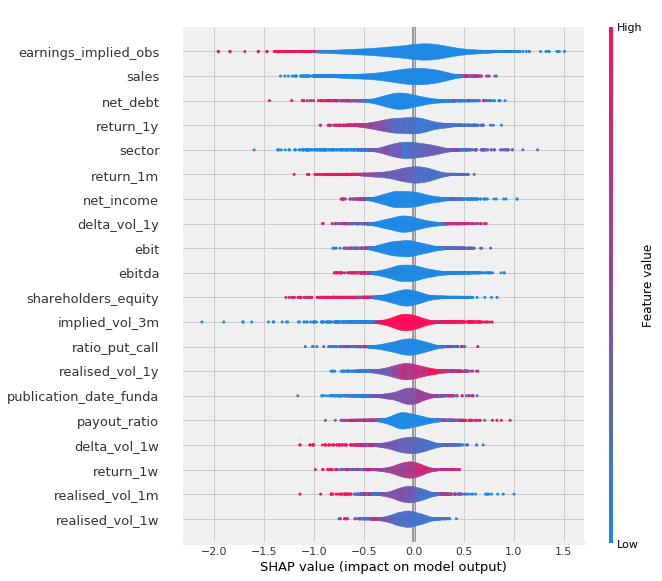

Wall time: 6.89 s


In [0]:
%%time
shap.summary_plot(tree_shap_values, features=X_test_boost,
                  feature_names=X_test_boost.columns, plot_type='violin',
                  max_display=20)

## AAA